# 8.4 内核PCA

内核是一种数学技术，可以将实例隐式映射到一个高维空间（称为特征空间），从而可以使用支持向量机来进行非线性分类和回归。可以将同样的技术应用于PCA，从而可以执行复杂的非线性投影来降低维度，这叫做内核PCA（kPCA）。**它通常擅长在投影后保留实例的聚类，有时甚至可以展开位于扭曲流形附近的数据。**

In [1]:
import sklearn
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [3]:
# 使用KernelPCA类以及RBF内核来执行kPCA
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

绘制使用线性内核（相当于简单地使用PCA类）、RBF内核和sigmoid内核减小为2维的瑞士卷图形

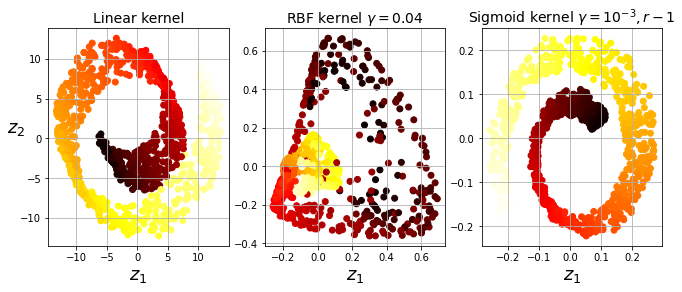

In [4]:
lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6/.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel $\gamma=10^{-3}, r-1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()


## 选择内核并调整超参数
由于kPCA是一种无监督学习算法，因此没有明显的性能指标可以帮助你选择最好的内核和超参数值。也就是说，降维通常是有监督学习任务的准备步骤，因此你可以使用网格搜索来选择在该任务上能获得最佳性能的内核和超参数。

下面的代码创建了一个两步流水线，首先使用kPCA将维度减少到二维，然后使用逻辑回归来分类。

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [7]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


另外一种完全无监督的方法是选择产生最低重构误差的内核和超参数。请注意，重建并不像使用线性PCA那样容易。以下是原因。图8-11显示了原始的瑞士卷3D数据集（左上）和使用RBF内核应用kPCA之后得到的2D数据集（右上）。多亏了内核技术，此变换在数学上等效于使用特征图$\phi$将训练集映射到无限维特征空间（右下），然后使用线性PCA将变换后的训练集投影到2D。

![fig. 8-11](./files/fig-8-11.png)


请注意，如何可以对一个给定的实例在缩小的空间中反转线性PCA，则重构点将位于特征空间中，而不是原始空间中。由于特征空间是无线维的，因此我们无法计算重构点，无法计算真实的重构误差。幸运的是，有可能在原始空间中找到一个点，该点将映射到重建点附件，这一点称为**重建原像**。一旦你有了原像，就可以测量其与原始实例的平方距离，然后可是选择内核和超参数，最大限度地减少次重构原像的误差。

如何执行重构呢？一种解决方案是训练有监督的回归模型，其中讲投影实例作为训练集，将原始值作为目标值。如果设置`fit_inverse_transform=True`，Scikit-Learn会自动执行此操作。


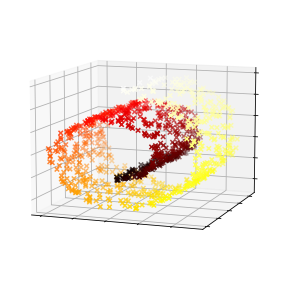

In [8]:
plt.figure(figsize=(6, 5))
X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([wz
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

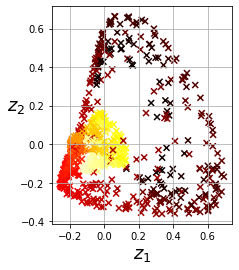

In [9]:

X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [10]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.043333333, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [11]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

1.2982482983138778e-26

**默认情况下，`fit_inverse_transform=False`，并且KernelPCA没有`inverse_transform()`方法。仅当你设置了`fit_inverse_transform=True`时，才会创建此方法。**